# INSTRUCTIONS

Workflow: Run each cell in order. Put or extract data into relevant folders as defined in section 2. Make remaining folders in drive.  **Cells denoted with * may require extra action.**


```
Folder Structure Suggested for Section 2:
drive/
    train_data/ <- input midis go here
    train_output/
        graphs/ <- train/val accuracy plots go here
        intermed/ <- intermediate weights, preprocessing go here
        stats/ (currently not being used)
        midi/ <- output midis go here
```




# 1 Imports

In [1]:
# Import Data Manip, Debug
import glob
import pickle
import numpy as np
import pandas as pd
import pdb
import matplotlib.pyplot as plt

# Import Music21
!pip install music21
from music21 import converter, instrument, note, chord, stream

# Import Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.regularizers import L1L2
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# stuff needed for colaboratory to connect with drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
··········


# 2 Mount and Set Directories*

In [3]:
# mount drive
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
DATA_FOLDER = 'drive/Project/train_data/folk'
GRAPHS_FOLDER = 'drive/Project/train_output/graphs'
MIDI_OUTPUT_FOLDER = 'drive/Project/train_output/midi'
INTERMED_FOLDER = 'drive/Project/train_output/intermed'
STATS_FOLDER = 'drive/Project/train_output/stats'

# data specific
FOLK_CORPUS = '/folk_'

# SET THIS TO ONE OF ABOVE (ACTION)
CORPUS = FOLK_CORPUS

# Notewise Root

# 3 Set Training Parameters*

In [0]:
# SET PARAMETERS (ACTION)
RESTS = False
ROOT_EXTRACTION = True
DURATION_BATCH_SIZE = 256
NOTE_BATCH_SIZE = 128
# SPECIFY PARAMETERS TO TEST AS LIST
DROPOUTS = 0
MODEL_SIZES = 512
EPOCHS = 10

# 4 Preprocess Data (MIDI Data Into Notes Corpus and Duration Corpus)

In [6]:
# Test

notes_corpus = []
durations_corpus = []

for file in glob.glob(DATA_FOLDER + "/*.mid"):
    try:
      print("Extracting MIDI File: ", file)
      midi_stream = converter.parse(file)

      notes = None

      partition = instrument.partitionByInstrument(midi_stream)

      if not RESTS:
        # No rests
        if partition: 
            notes = partition.parts[0].recurse()
        else: 
            notes = midi_stream.flat.notes
      else:
        # With rests
        if partition: 
            notes = partition.parts[0].recurse()
        else: 
            notes = midi_stream.notesAndRests
          
      in_song_notes = []
      in_song_durations = []
      for element in notes:
          in_song_durations.append(element.duration.quarterLength)
          if isinstance(element, note.Note):
              in_song_notes.append(str(element.pitch))
          elif RESTS and isinstance(element, note.Rest):
              in_song_notes.append("R")
          elif isinstance(element, chord.Chord):
              if ROOT_EXTRACTION:
                  in_song_notes.append(element.root().nameWithOctave)
              else:
                  in_song.append('.'.join(str(n) for n in element.normalOrder))
    except:
      pass
    
    notes_corpus.append(in_song_notes)
    durations_corpus.append(in_song_durations)
            
# Write
with open(INTERMED_FOLDER + CORPUS + 'notes_corpus', 'wb+') as filepath:
    pickle.dump(notes_corpus, filepath)
    
with open(INTERMED_FOLDER + CORPUS + 'durations_corpus', 'wb+') as filepath:
    pickle.dump(durations_corpus, filepath)

Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4971.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4965.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4966.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4976.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4962.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4963.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4981.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4980.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4972.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4979.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4977.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4974.mid
Extracting MIDI File:  drive/Project/train_data/folk/sessiontune4982.mid
Extracting MIDI File:  drive/Project/train_data/fol

# 5 Preprocess Corpus Into Train Data

## 5.1 Notes Corpus

In [7]:
# load notes corpus
with open(INTERMED_FOLDER + CORPUS + 'notes_corpus', 'rb') as filepath:
    notes_corpus = pickle.load(filepath)
    
# If doing learning for one song at a time only
flattened_notes_corpus = []
for song_notes in notes_corpus:
    flattened_notes_corpus += song_notes

vocab_size = len(set(flattened_notes_corpus))
print(vocab_size)

# Produce input output sequences
window_size = 60
note_sequence_input = []
next_note_output = []

notes = sorted(set(flattened_notes_corpus))
note2int = dict((note, num) for num, note in enumerate(notes))

for i in range(0, len(notes_corpus)):
    for j in range(0, len(notes_corpus[i]) - window_size):
        current_sequence = [note2int[note] for note in notes_corpus[i][j:window_size+j]]
        next_note = note2int[notes_corpus[i][window_size+j]]
        note_sequence_input.append(current_sequence)
        next_note_output.append(next_note)

43


In [8]:
# check train and label shapes
training_data = np.reshape(note_sequence_input, (len(note_sequence_input), window_size , 1))
training_data = training_data / float(vocab_size)
print('Train shape: ' + str(training_data.shape))
training_label = np_utils.to_categorical(next_note_output)
print('Label shape: ' + str(training_label.shape))

Train shape: (649804, 60, 1)
Label shape: (649804, 43)


## 5.2 Durations Corpus

In [9]:
# load notes corpus
with open(INTERMED_FOLDER + CORPUS + 'durations_corpus', 'rb') as filepath:
    duration_corpus = pickle.load(filepath)

# Learn on one song at a time
flattened_duration_corpus = []
for song_durations in duration_corpus:
    flattened_duration_corpus += song_durations
    
import collections
counter = collections.Counter(flattened_duration_corpus)
print(counter)


duration_vocab_size = len(set(flattened_duration_corpus))
print(duration_vocab_size)

# Produce input output sequences
duration_window_size = 30
duration_sequence_input = []
next_duration_output = []

durations = sorted(set(flattened_duration_corpus))
duration2int = dict((duration, num) for num, duration in enumerate(durations))

print(duration2int)
# Write
with open(INTERMED_FOLDER + "/edm_duration_counter", 'wb+') as filepath:
    pickle.dump(counter, filepath)

for i in range(0, len(duration_corpus)):
    for j in range(0, len(duration_corpus[i]) - duration_window_size):
        current_duration_sequence = [duration2int[note] for note in duration_corpus[i][j:duration_window_size+j]]
        next_duration = duration2int[duration_corpus[i][duration_window_size+j]]
        duration_sequence_input.append(current_duration_sequence)
        next_duration_output.append(next_duration)

Counter({0.5: 648555, 1.0: 97616, Fraction(1, 3): 67066, 0.25: 61594, Fraction(2, 3): 29054, 1.5: 21217, 0.0: 15440, 2.0: 6627, 0.75: 1722, 3.0: 1328, 2.5: 405, Fraction(5, 3): 294, 4.0: 247, 5.0: 160, Fraction(4, 3): 88, 1.25: 59, 3.5: 59, 6.0: 54, 1.75: 47, 4.5: 46, 2.25: 22, 7.0: 10, 6.5: 7, 8.0: 6, Fraction(8, 3): 5, 5.5: 5, 4.25: 4, Fraction(7, 3): 4, Fraction(17, 3): 2, 7.5: 1})
30
{0.0: 0, 0.25: 1, Fraction(1, 3): 2, 0.5: 3, Fraction(2, 3): 4, 0.75: 5, 1.0: 6, 1.25: 7, Fraction(4, 3): 8, 1.5: 9, Fraction(5, 3): 10, 1.75: 11, 2.0: 12, 2.25: 13, Fraction(7, 3): 14, 2.5: 15, Fraction(8, 3): 16, 3.0: 17, 3.5: 18, 4.0: 19, 4.25: 20, 4.5: 21, 5.0: 22, 5.5: 23, Fraction(17, 3): 24, 6.0: 25, 6.5: 26, 7.0: 27, 7.5: 28, 8.0: 29}


In [10]:
# check train and label shapes
duration_training_data = np.reshape(duration_sequence_input, (len(duration_sequence_input), duration_window_size , 1))
duration_training_data = duration_training_data / float(duration_vocab_size)
print('Train shape: ' + str(duration_training_data.shape))
duration_training_label = np_utils.to_categorical(next_duration_output)
print('Label shape: ' + str(duration_training_label.shape))

Train shape: (799861, 30, 1)
Label shape: (799861, 30)


# 6 Train

## 6.1 Helpers to Create Model

In [0]:
from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

In [0]:
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import BatchNormalization

def create_model(network_input, n_vocab, model_size, dropout, window_size):
  model = Sequential()
  reg = L1L2(0, 0)
  
  # CNN
  model.add(Conv1D(512, 5))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  #LSTM
  model.add(LSTM(
      model_size,
      input_shape=(network_input.shape[1], network_input.shape[2]),
      return_sequences=True,
      dropout=dropout, recurrent_dropout=0.3
  ))
  model.add(CuDNNLSTM(model_size, return_sequences=True, kernel_regularizer=reg))
  model.add(Dropout(dropout))
  model.add(CuDNNLSTM(model_size, return_sequences=True, kernel_regularizer=reg))
  model.add(Attention(window_size))
  model.add(Dense(128))
  model.add(Dropout(dropout))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def create_callback_list(model_size, dropout, model_type):
  filepath = INTERMED_FOLDER + '/%skarpathy-model-weights-%s-%s-%s.hdf5' % (CORPUS, model_type, model_size, dropout)
  model_checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
  )
  return [model_checkpoint], filepath

# acc history
def setup_plot(dropout, size):
  plt.title('Model Accuracy vs. Epoc with Dropout=%s Size=%s' % (dropout, size))
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  
def plot_history(history, model_type, dropout, size):
  plt.plot(history.history['acc'], label="%s train accuracy" % model_type)
  plt.plot(history.history['val_acc'], label="%s val accuracy" % model_type)

def save_plot(file_path):
  plt.legend()
  plt.savefig(file_path)
  plt.clf()
  
def predict_duration(model, WEIGHT_PATH):
  # Prediction
  model.load_weights(WEIGHT_PATH)
  starting_sequence = np.random.randint(219, size=duration_window_size)
  pattern_sequence = starting_sequence.tolist()
  prediction_output = []

  duration2note = dict((num, note) for num, note in enumerate(durations))
  print (duration2note)
  
  for i in range(400):
      prediction_input = np.reshape(pattern_sequence, (1, len(pattern_sequence), 1))
      prediction_input = prediction_input / float(duration_vocab_size)

      if i%3 == 0:   
          print('\r', 'Predicting.  Duration: ', i, end='')  
      if i%3 == 1:   
          print('\r', 'Predicting.. Duration: ', i, end='')
      if i%3 == 2:   
          print('\r', 'Predicting...Duration: ', i, end='')
      prediction = model.predict(prediction_input, verbose=0)

      prediction_values = np.arange(len(prediction[0]))
      prediction_prob = np.asarray(list(prediction[0])) / float(sum(prediction[0]))

      # Most probable note prediction
#       index = np.argmax(prediction)
#       note_instance = duration2note[index]
#       prediction_output.append(note_instance)
      index = np.random.choice(prediction_values, 1, p=prediction_prob)
      note_instance = duration2note[int(index[0])]
      prediction_output.append(note_instance)

      pattern_sequence.append(index)
      pattern_sequence = pattern_sequence[1:len(pattern_sequence)]    

  prediction_output = prediction_output[300:len(prediction_output)]

  # Write
  with open(INTERMED_FOLDER + ("%sduration_prediction_output" % CORPUS), 'wb+') as filepath:
      pickle.dump(prediction_output, filepath)
  
  return prediction_output

def predict_note(model, WEIGHT_PATH):
  model.load_weights(WEIGHT_PATH)
  # Prediction
  starting_sequence = np.random.randint(219, size=window_size)
  pattern_sequence = starting_sequence.tolist()
  prediction_output = []

  int2note = dict((num, note) for num, note in enumerate(notes))
  print (int2note)

  for i in range(400):
      prediction_input = np.reshape(pattern_sequence, (1, len(pattern_sequence), 1))
      prediction_input = prediction_input / float(vocab_size)

      if i%3 == 0:   
          print('\r', 'Predicting.  Note: ', i, end='')  
      if i%3 == 1:   
          print('\r', 'Predicting.. Note: ', i, end='')
      if i%3 == 2:   
          print('\r', 'Predicting...Note: ', i, end='')
      prediction = model.predict(prediction_input, verbose=0)

#       prediction_values = np.arange(len(prediction[0]))
#       prediction_prob = np.asarray(list(prediction[0])) / float(sum(prediction[0]))
#       print(prediction_prob)

      # Most probable note prediction
      index = np.argmax(prediction)
      note_instance = int2note[index]
      prediction_output.append(note_instance)

      # Predict based on prob dist
#       index = np.random.choice(prediction_values, 1, p=prediction_prob)
  #     print(index[0])
  #     print(type(index[0]))
#       note_instance = int2note[int(index[0])]
#       prediction_output.append(note_instance)

      pattern_sequence.append(index)
      pattern_sequence = pattern_sequence[1:len(pattern_sequence)]    

  prediction_output = prediction_output[300:len(prediction_output)]
  # Write
  with open(INTERMED_FOLDER + ("%snotes_prediction_output" % CORPUS), 'wb+') as filepath:
      pickle.dump(prediction_output, filepath)
  return prediction_output

def output_midi(prediction_output, duration_prediction_output, dropout, model_size):
  offset = 0
  output_notes = []
  for pattern, duration in zip(prediction_output, duration_prediction_output):

      if ('.' in pattern) or pattern.isdigit():
          chord_array = pattern.split('.')
          chord_notes = []
          for note_instance in chord_array:
              note_object = note.Note(int(note_instance))
              note_object.duration.quarterLength = duration
              note_object.storedInstrument = instrument.Piano()
              chord_notes.append(note_object)
          chord_object = chord.Chord(chord_notes)
          chord_object.offset = offset
          output_notes.append(chord_object)
      elif 'R' == pattern:
          note_object = note.Rest()
          note_object.duration.quarterLength = duration
          note_object.offset = offset
          output_notes.append(note_object)
      else:
          note_object = note.Note(pattern)
          note_object.duration.quarterLength = duration
          note_object.offset = offset
          note_object.storedInstrument = instrument.Piano()
          output_notes.append(note_object)

      offset += 0.5

  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp=MIDI_OUTPUT_FOLDER + CORPUS + '%s_%s.mid' % (dropout, model_size))
  print('\nWrote midi...')

## 6.2 Preprocessing Optimization

Running duration training on notewise with rests:False and root extraction:True
Train on 639888 samples, validate on 159973 samples
Epoch 1/10
639888/639888 [==============================] - 359s 561us/step - loss: 0.7181 - acc: 0.7708 - val_loss: 0.7103 - val_acc: 0.7722
Epoch 2/10
639888/639888 [==============================] - 355s 555us/step - loss: 0.5764 - acc: 0.8153 - val_loss: 0.6218 - val_acc: 0.8045
Epoch 3/10
639888/639888 [==============================] - 355s 555us/step - loss: 0.4970 - acc: 0.8371 - val_loss: 0.5686 - val_acc: 0.8162
Epoch 4/10
639888/639888 [==============================] - 355s 555us/step - loss: 0.4588 - acc: 0.8480 - val_loss: 0.5611 - val_acc: 0.8185
Epoch 5/10
639888/639888 [==============================] - 355s 554us/step - loss: 0.4245 - acc: 0.8588 - val_loss: 0.5713 - val_acc: 0.8210
Epoch 6/10
639888/639888 [==============================] - 355s 555us/step - loss: 0.3883 - acc: 0.8703 - val_loss: 0.5949 - val_acc: 0.8171
Epoch 7/10
63988

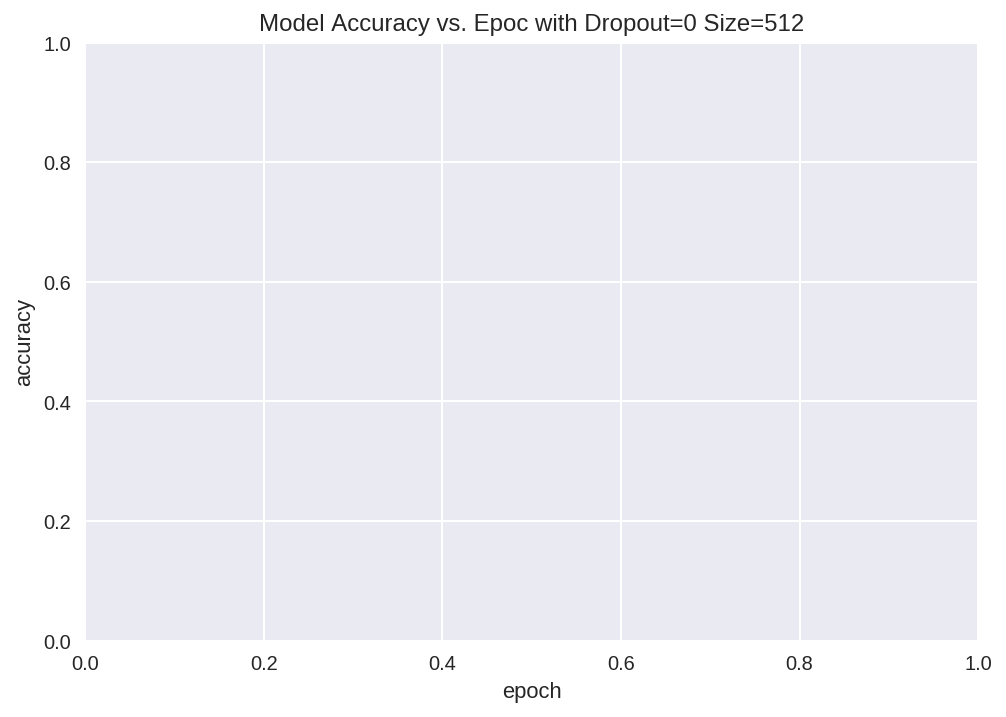

In [31]:
notes_histories = {}
duration_histories = {}

dropout, model_size = DROPOUTS, MODEL_SIZES
setup_plot(dropout, model_size)
print('Running duration training on notewise with rests:%s and root extraction:%s' % (RESTS, ROOT_EXTRACTION))
duration_callbacks, duration_weight_path = create_callback_list('duration', dropout, model_size)
duration_model = create_model(duration_training_data, duration_training_label.shape[1], model_size, dropout, 13)
duration_histories[(dropout, model_size)] = duration_model.fit(duration_training_data, duration_training_label, epochs=EPOCHS, batch_size=DURATION_BATCH_SIZE, callbacks=duration_callbacks, validation_split=0.2)


{0: 0.0, 1: 0.25, 2: Fraction(1, 3), 3: 0.5, 4: Fraction(2, 3), 5: 0.75, 6: 1.0, 7: 1.25, 8: Fraction(4, 3), 9: 1.5, 10: Fraction(5, 3), 11: 1.75, 12: 2.0, 13: 2.25, 14: Fraction(7, 3), 15: 2.5, 16: Fraction(8, 3), 17: 3.0, 18: 3.5, 19: 4.0, 20: 4.25, 21: 4.5, 22: 5.0, 23: 5.5, 24: Fraction(17, 3), 25: 6.0, 26: 6.5, 27: 7.0, 28: 7.5, 29: 8.0}
 Predicting.  Duration:  399

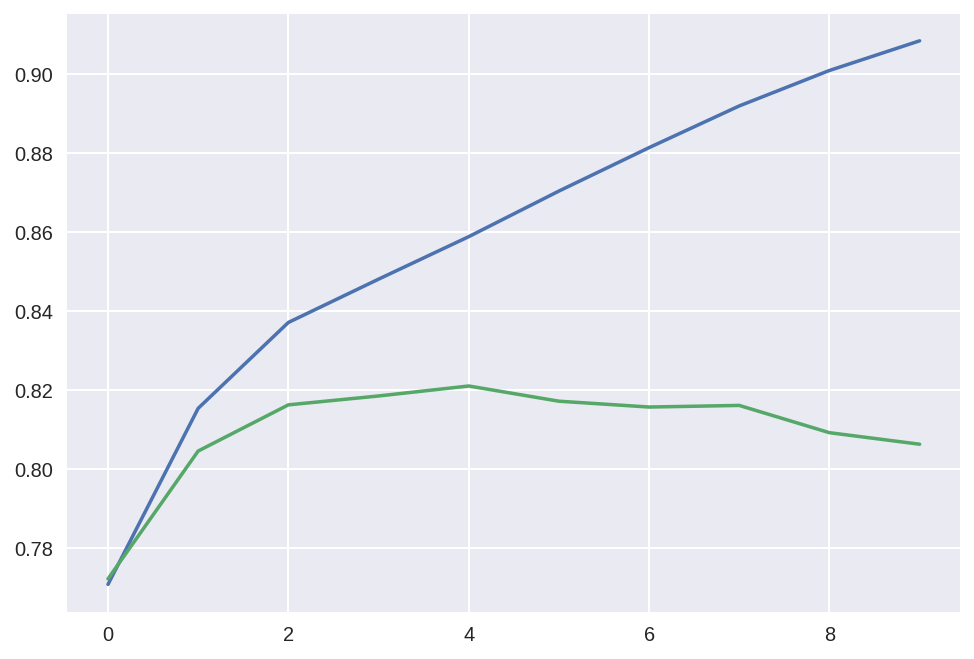

In [32]:
plot_history(duration_histories[(dropout, model_size)], 'Durations', dropout, model_size)
# output intermed duration
duration_prediction = predict_duration(duration_model, duration_weight_path)

In [33]:
print('\n\nRunning notes training on d:%s s:%s' % (dropout, model_size))
notes_callbacks, note_weight_path = create_callback_list('notes', dropout, model_size)
notes_model = create_model(training_data, training_label.shape[1], model_size, dropout, 28)
notes_histories[(dropout, model_size)] = notes_model.fit(training_data, training_label, epochs=EPOCHS, batch_size=NOTE_BATCH_SIZE, callbacks=notes_callbacks, validation_split=0.2)
plot_history(notes_histories[(dropout, model_size)], 'Notes', dropout, model_size)
save_plot(GRAPHS_FOLDER + CORPUS + 'dropout=%s_size=%s.jpg' % (dropout, model_size))
# output intermed notes
note_prediction = predict_note(notes_model, note_weight_path)



Running notes training on d:0 s:512
Train on 519843 samples, validate on 129961 samples
Epoch 1/10
519843/519843 [==============================] - 766s 1ms/step - loss: 2.5700 - acc: 0.1494 - val_loss: 2.4377 - val_acc: 0.1726
Epoch 2/10
519843/519843 [==============================] - 762s 1ms/step - loss: 2.2289 - acc: 0.2320 - val_loss: 2.2985 - val_acc: 0.2421
Epoch 3/10
519843/519843 [==============================] - 762s 1ms/step - loss: 1.9387 - acc: 0.3323 - val_loss: 2.2815 - val_acc: 0.2678
Epoch 4/10
519843/519843 [==============================] - 762s 1ms/step - loss: 1.6907 - acc: 0.4229 - val_loss: 2.3896 - val_acc: 0.2695
Epoch 5/10
519843/519843 [==============================] - 761s 1ms/step - loss: 1.4682 - acc: 0.5021 - val_loss: 2.5365 - val_acc: 0.2703
Epoch 6/10
519843/519843 [==============================] - 762s 1ms/step - loss: 1.2747 - acc: 0.5702 - val_loss: 2.6241 - val_acc: 0.2704
Epoch 7/10
519843/519843 [==============================] - 762s 1ms/s

<Figure size 576x396 with 0 Axes>

In [34]:
# output final midi
output_midi(note_prediction, duration_prediction, dropout, model_size)


Wrote midi...


In [0]:
# output intermed duration
duration_prediction = predict_duration(duration_model, "folk_karpathy-model-weights-512-duration-0.hdf5")

# output intermed notes
note_prediction = predict_note(notes_model, "folk_karpathy-model-weights-512-notes-0.hdf5")

# output final midi
output_midi(note_prediction, duration_prediction, dropout, model_size)